# Evolving a Lunar Lander with differentiable Genetic Programming

## Installation
To install the required libraries run the command:

In [1]:
!pip install -r requirements.txt

## Imports
Imports from the standard genepro-multi library are done here. Any adjustments (e.g. different operators) should be made in the notebook. For example:

```
class SmoothOperator(Node):
  def __init__(self):
    super(SmoothOperator,self).__init__()
    self.arity = 1
    self.symb = "SmoothOperator"

  def _get_args_repr(self, args):
    return self._get_typical_repr(args,'before')

  def get_output(self, X):
    c_outs = self._get_child_outputs(X)
    return np.smoothOperation(c_outs[0])

  def get_output_pt(self, X):
    c_outs = self._get_child_outputs_pt(X)
    return torch.smoothOperation(c_outs[0])
```

In [2]:
import gymnasium as gym

from genepro.node_impl import *
from genepro.evo import Evolution
from genepro.node_impl import Constant

import torch
import torch.optim as optim

import random
import os
import copy
from collections import namedtuple, deque

import matplotlib.pyplot as plt
from matplotlib import animation

## Reinforcement Learning Setup
Here we first setup the Gymnasium environment. Please see https://gymnasium.farama.org/environments/box2d/lunar_lander/ for more information on the environment. 

Then a memory buffer is made. This is a buffer in which state transitions are stored. When the buffer reaches its maximum capacity old transitions are replaced by new ones.

A frame buffer is initialised used to later store animation frames of the environment.

In [3]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

In [4]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def __iadd__(self, other):
      self.memory += other.memory
      return self 

    def __add__(self, other):
      self.memory = self.memory + other.memory 
      return self

In [5]:
frames = []

## Fitness Function

Here you get to be creative. The default setup evaluates 5 episodes of 300 frames. Think of what action to pick and what fitness function to use. The Multi-tree takes an input of $n \times d$ where $n$ is a batch of size 1.

In [6]:
def fitness_function_pt(multitree, num_episodes=5, episode_duration=300, render=False, ignore_done=False):
  memory = ReplayMemory(10000)
  rewards_list = []

  for _ in range(num_episodes):
    # get initial state of the environment
    observation = env.reset()
    observation = observation[0]
    rewards = []
    
    for _ in range(episode_duration):
      if render:
        frames.append(env.render())

      input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
      
      # what goes here?
      action =  torch.argmax(multitree.get_output_pt(input_sample))
      observation, reward, terminated, truncated, info = env.step(action.item())
      rewards.append(reward)
      output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
      memory.push(input_sample, torch.tensor([[action.item()]]), output_sample, torch.tensor([reward]))
      if (terminated or truncated) and not ignore_done:
        break
    rewards_list.append(rewards)

  fitness = np.mean([np.sum(rewards) for rewards in rewards_list])
  
  return fitness, memory

## Selection function
Here we use a boolean to check how the variation of the population is. If at some point it is above a threshold, we switch our seleciton function. We first use Roulette Wheel selection, then switch to tournament selection. This is a simple way to ensure diversity in the population.

In [7]:
def roulette_wheel_selection(population, number_to_select):
    fitnesses = [ind.fitness for ind in population]
    total_fitness = sum(fitnesses)
    selection_probs = [f / total_fitness for f in fitnesses]
    selected = []
    for i in range(number_to_select):
        selected_index = np.random.choice(len(population), p=selection_probs)
        selected.append(population[selected_index])
    return selected

In [8]:
from genepro.selection import tournament_selection
def combined_selection(population, number_to_select,tournament_size):
    # max difference action is leading
    min_fitness = population[0].fitness
    max_fitness = population[0].fitness
    sum_fitness = 0
    for i in range(len(population)):
        current_fitness = population[i].fitness
        if current_fitness < min_fitness:
            min_fitness = current_fitness
        if current_fitness > max_fitness:
            max_fitness = current_fitness
        sum_fitness += current_fitness
    average_fitness = sum_fitness / len(population)
    if abs(max_fitness - average_fitness) < abs(min_fitness - average_fitness):
        has_deviated = True
    else:
        has_deviated = False
    if has_deviated:
        # Use tournament selection
        print("Using tournament selection")
        return tournament_selection(population, number_to_select, tournament_size=tournament_size)
    else:
        # Use roulette wheel selection
        print("Using roulette wheel selection")
        return roulette_wheel_selection(population, number_to_select)

## Evolution Setup
Here the leaf and internal nodes are defined. Think about the odds of sampling a constant in this default configurations. Also think about any operators that could be useful and add them here.

Adjust the population size (multiple of 8 if you want to use the standard tournament selection), max generations and max tree size to taste. Be aware that each of these settings can increase the runtime.

In [9]:
num_features = env.observation_space.shape[0]
leaf_nodes = [Feature(i) for i in range(num_features)]
leaf_nodes = leaf_nodes + [Constant()] # Think about the probability of sampling a coefficient
internal_nodes = [Plus(),Minus(),Times(),Div()] #Add your own operators here
selection_function = {
    "fun":combined_selection,
    "kwargs":{"tournament_size": 16}}
evo = Evolution(
  fitness_function_pt, internal_nodes, leaf_nodes,
  4,
  pop_size=128,
  max_gens=30,
  max_tree_size=31,
  selection=selection_function,
  n_jobs=8,
  verbose=True)

## Evolve
Running this cell will use all the settings above as parameters

In [10]:
evo.evolve()

Using tournament selection
gen: 1,	best of gen fitness: -55.278,	best of gen size: 25
Using tournament selection
gen: 2,	best of gen fitness: -39.067,	best of gen size: 27
Using tournament selection
gen: 3,	best of gen fitness: -39.067,	best of gen size: 27
Using tournament selection
gen: 4,	best of gen fitness: -39.067,	best of gen size: 27
Using tournament selection
gen: 5,	best of gen fitness: 19.186,	best of gen size: 25
Using tournament selection
gen: 6,	best of gen fitness: 19.186,	best of gen size: 25
Using tournament selection
gen: 7,	best of gen fitness: 19.186,	best of gen size: 25
Using tournament selection
gen: 8,	best of gen fitness: 19.186,	best of gen size: 25
Using tournament selection
gen: 9,	best of gen fitness: 19.186,	best of gen size: 25
Using tournament selection
gen: 10,	best of gen fitness: 19.186,	best of gen size: 25
Using tournament selection
gen: 11,	best of gen fitness: 19.186,	best of gen size: 25
Using tournament selection
gen: 12,	best of gen fitness: 48

# Test

In [21]:
def get_test_score(tree):
    rewards_list = []

    for i in range(10):
      # get initial state
      observation = env.reset(seed=i)
      observation = observation[0]
      rewards = []

      for _ in range(500):    
        # build up the input sample for GP
        input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        # get output (squeezing because it is encapsulated in an array)
        output = tree.get_output_pt(input_sample)
        action = torch.argmax(output)# What goes here?
        observation, reward, terminated, truncated, info = env.step(action.item())
        rewards.append(reward)


        output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        if (terminated or truncated):
            break
      rewards_list.append(rewards)

    fitness = np.mean([np.sum(r) for r in rewards_list])
    
    return fitness

best = evo.best_of_gens[-1]

print(best.get_readable_repr())
print(get_test_score(best))

['(1.770671005769292-(((0.4800244709863126-((x_2+-1.9488407373428345)/((x_3+2.243025779724121)/(x_3-x_6))))+-1.9923291206359863)/((x_3+2.2668099403381348)/(x_3-x_6))))', '((((x_6*x_6)*(x_2+1.4883975982666016))*(x_0+(x_0*x_5)))-(x_4/((x_6+x_2)*(x_0-x_0))))', '(((x_1/(x_4/x_4))*(x_4/(x_3-x_2)))*(x_5+(x_4+x_2)))', '(x_1-0.8575727939605713)']
-87.67775066716176


In [22]:
# Save evo.best_of_gens to file
if not os.path.exists("experiments"):
    os.makedirs("experiments")
best_tree_path = os.path.join("experiments", "best_gens_n=126_ng=30_t=31_only_tournament.pt")
torch.save(evo.best_of_gens, best_tree_path)

In [23]:
# Read best tree from file
best_tree = torch.load(best_tree_path)
# Test the best tree
print("Test score of the best tree:", get_test_score(best_tree[-1]))

C:\Users\shirl\AppData\Local\Temp\ipykernel_37460\1101362267.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_tree = torch.load(best_tree_path)


Test score of the best tree: -87.67775066716176


## Make an animation
Here the best evolved individual is selected and one episode is rendered. Make sure to save your lunar landers over time to track progress and make comparisons.

MovieWriter imagemagick unavailable; using Pillow instead.


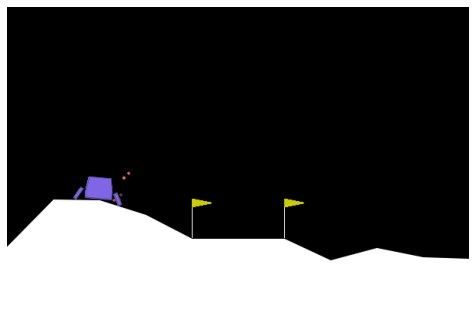

In [12]:
frames = []

# gist to save gif from https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553
def save_frames_as_gif(frames, path='./', filename='evolved_lander.gif'):
  plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
  patch = plt.imshow(frames[0])
  plt.axis('off')
  def animate(i):
      patch.set_data(frames[i])
  anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
  anim.save(path + filename, writer='imagemagick', fps=60)

frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames)

## Play animation

<img src="evolved_lander.gif" width="750">

## Optimisation
The coefficients in the multi-tree aren't optimised. Here Q-learning (taken from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) is used to optimise the weights further. Incorporate coefficient optimisation in training your agent(s). Coefficient Optimisation can be expensive. Think about how often you want to optimise, when, which individuals etc.

In [15]:
batch_size = 128
GAMMA = 0.99

constants = best.get_subtrees_consts()

if len(constants)>0:
  optimizer = optim.AdamW(constants, lr=1e-3, amsgrad=True)

for _ in range(500):

  if len(constants)>0 and len(evo.memory)>batch_size:
    target_tree = copy.deepcopy(best)

    transitions = evo.memory.sample(batch_size)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), dtype=torch.bool)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                               if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = best.get_output_pt(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(batch_size, dtype=torch.float)
    with torch.no_grad():
      next_state_values[non_final_mask] = target_tree.get_output_pt(non_final_next_states).max(1)[0].float()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
   
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(constants, 100)
    optimizer.step()

print(best.get_readable_repr())
print(get_test_score(best))

['(1.770671005769292-(((0.4800244709863126-((x_2+-1.9488407373428345)/((x_3+2.243025779724121)/(x_3-x_6))))+-1.9923291206359863)/((x_3+2.2668099403381348)/(x_3-x_6))))', '((((x_6*x_6)*(x_2+1.4883975982666016))*(x_0+(x_0*x_5)))-(x_4/((x_6+x_2)*(x_0-x_0))))', '(((x_1/(x_4/x_4))*(x_4/(x_3-x_2)))*(x_5+(x_4+x_2)))', '(x_1-0.8575727939605713)']
-87.67774671938915


MovieWriter imagemagick unavailable; using Pillow instead.


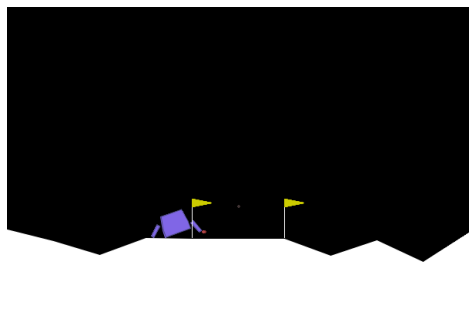

In [16]:
frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames, filename='evolved_lander_RL.gif')

<img src="evolved_lander_RL.gif" width="750">